# Read a binary (`.bin`) file

Some entities have datasets hosted as binary files (NASA, NSIDC). This notebook shows how to read **some*** binary files with Python, into a `numpy` array. 

*binary files can have any type of structure, e.g. with header bytes that have metadata / information. This notebook just deals with flat binary files, in which all of the bytes correspond to a part of the desired array, and are in regular row-major order, beginning with the upper left pixel of the grid and proceeding across the top row, etc. Data are double-precision 8-byte floating point values.

Also note that the author of this notebook doesn't really know much about this file format in general. Just recording some things that worked.

### Sample data

This notebook will make use of the following data from NSIDC's servers:  
* `<prefix>pub/DATASETS/NOAA/G02172/binary/nic_climo_1972_2007_06_med.v0.bin` - gridded median ice climatology 1972-2007 for June, on the NSIDC NA25 EASE-Grid
* `<prefix>pub/tools/easegrid/lowres_latlon/Na25LATLSB` - latitude values of NA25 EASE-Grid centerpoints
* `<prefix>pub/tools/easegrid/lowres_latlon/Na25LONLSB` - longitude values NA25 EASE-Grid centerpoints

(prefix is sidads.colorado.edu/ for FTP, https://daacdata.apps.nsidc.org/ for https)

### Read the contents of these files

`numpy` has made this pretty painless. Using the `numpy.fromfile` function, you can "[Construct an array from data in a text or binary file.](https://numpy.org/doc/stable/reference/generated/numpy.fromfile.html#numpy.fromfile)". You just have to know the data type.

#### `nic_climo_1972_2007_06_med.v0.bin`

From the dataset page for this file, which contains the [user guide](https://nsidc.org/data/G02172/versions/1?qt-data_set_tabs=3#qt-data_set_tabs), we are told that "The files are flat binary, 1-byte unsigned byte data presented in the NSIDC NA25 EASE-Grid format (north azimuthal equal area projection, nominal 25 km resolution 361 x 361 grid)". 

So we know our data type should be `numpy.ubyte`, which is the same as `numpy.uint8`:

In [1]:
import numpy as np

print(np.ubyte)

<class 'numpy.uint8'>


So we will set this as the `dtype` parameter for `fromfile()`:

In [2]:
with open("data/nic_climo_1972_2007_06_med.v0.bin", "rb") as f:
    arr = np.fromfile(f, np.uint8)
    
print(arr)
print(arr.shape)

[0 0 0 ... 0 0 0]
(130321,)


Since this should be a 361 x 361 grid, we reshape to that, and it should be a nice square:

In [3]:
arr = arr.reshape((361, 361))
print(arr.shape)

(361, 361)


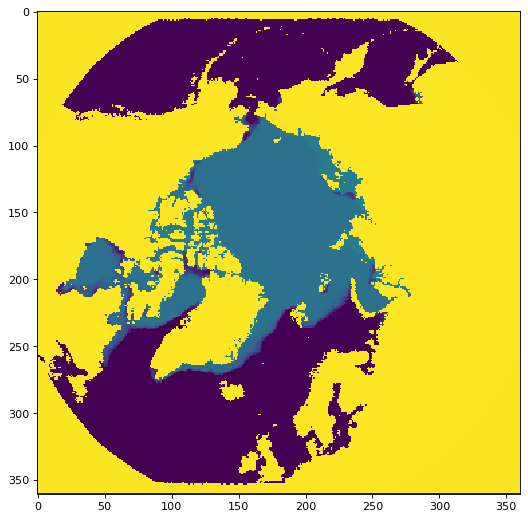

In [4]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 8), dpi=80)
plt.imshow(arr, interpolation="none")
plt.show()

Neat!

#### `Na25LATLSB` and `Na25LATLSB`

Nevermind that these don't have extensions, the names are unchanged from how they are hosted by NSIDC. They can still be read as binary files. Who knows why this was done.

These files are on the same grid, and so should have the same shape, but it looks like they are a different data type, so that the necessary precision for the lon / lat values can be stored. See the NSIDC page on the geolocation grids to find that "[These geolocation files contain flat, binary arrays of 4-byte integers containing the latitude or longitude of the respective grid cell in hundred-thousandth degrees. The user should divide the stored integer value by 100,000.](https://nsidc.org/data/ease/tools#geo_data_files)". 

4-bytes? That's 32 bits! We have just the data type for that: `numpy.int32`.

In [5]:
with open("data/Na25LATLSB") as f:
    lat_arr = np.fromfile(f, np.int32).reshape((361, 361))

with open("data/Na25LONLSB") as f:
    lon_arr = np.fromfile(f, np.int32).reshape((361, 361))

And again, reshaping to (361, 361) should proceed without error. If you mis-specified the `dtype` to something incorrect, you might find out by way of not being able to reshape to the expected array:

In [6]:
with open("data/Na25LATLSB") as f:
    lat_arr = np.fromfile(f, np.byte).reshape((361, 361))

ValueError: cannot reshape array of size 521284 into shape (361,361)

...or you might not know you're wrong!!

In [7]:
with open("data/Na25LATLSB") as f:
    lat_arr = np.fromfile(f, np.float32).reshape((361, 361))
    
print(lat_arr)

[[4.189454e-39 4.215212e-39 4.240874e-39 ... 4.240874e-39 4.215212e-39
  4.189454e-39]
 [4.215212e-39 4.241019e-39 4.266728e-39 ... 4.266728e-39 4.241019e-39
  4.215212e-39]
 [4.240874e-39 4.266728e-39 4.292487e-39 ... 4.292487e-39 4.266728e-39
  4.240874e-39]
 ...
 [4.240874e-39 4.266728e-39 4.292487e-39 ... 4.292487e-39 4.266728e-39
  4.240874e-39]
 [4.215212e-39 4.241019e-39 4.266728e-39 ... 4.266728e-39 4.241019e-39
  4.215212e-39]
 [4.189454e-39 4.215212e-39 4.240874e-39 ... 4.240874e-39 4.215212e-39
  4.189454e-39]]


So watch out.

And remember to divide by 100,000 to get the floating point values:

In [8]:
s = 100000
lat_arr = lat_arr / s
lon_arr = lon_arr / s

Plots for good measure:

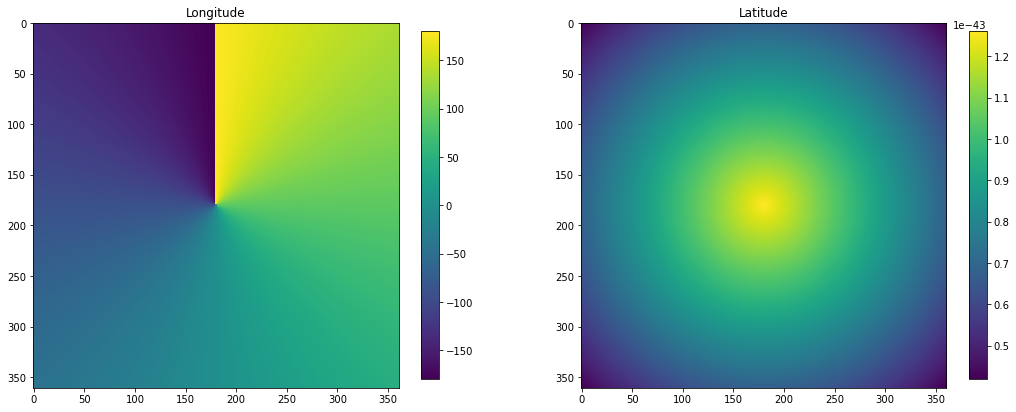

In [9]:
fig, axs = plt.subplots(1, 2, figsize=(18, 8))
im = axs[0].imshow(lon_arr, interpolation="none")
axs[0].set_title("Longitude")
fig.colorbar(im, ax=axs[0], shrink=0.8)
im = axs[1].imshow(lat_arr, interpolation="none")
axs[1].set_title("Latitude")
fig.colorbar(im, ax=axs[1], shrink=0.8)
plt.show()

For more reading, check out this [python module in SNAP's `hsia` repository](https://github.com/ua-snap/hsia/blob/95f66495b51cc80540ba27f04d69bf4e15fe7fde/hsia/seaice.py), that works with binary NASA files from NSIDC ([NSIDC-0051 dataset](https://nsidc.org/data/nsidc-0051)) that **do** have header information that needs to be properly accounted for, using metadata provided along with the dataset (originally -  some links seem broken).